In [1]:
from pint.models import get_model
from pint.simulation import make_fake_toas_fromtim
from pint.logging import setup as setup_log
from pint.fitter import Fitter

from io import StringIO
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import corner

from joblib import delayed, Parallel

/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
setup_log(level="WARNING")

1

In [7]:
m = get_model("sim2.par")

In [17]:
def simulate_and_measure():
    setup_log(level="WARNING")
    
    t = make_fake_toas_fromtim("sim2.tim", m, add_noise=True, add_correlated_noise=True)
    
    ftr = Fitter.auto(t, m)
    ftr.fit_toas()

    print(
        ftr.model.EFAC1.value, 
        ftr.model.EFAC1.uncertainty_value, 
        ftr.model.ECORR1.value, 
        ftr.model.ECORR1.uncertainty_value
    )

    return (
        ftr.model.EFAC1.value, 
        ftr.model.EFAC1.uncertainty_value, 
        ftr.model.ECORR1.value, 
        ftr.model.ECORR1.uncertainty_value
    )

In [ ]:
results = Parallel(n_jobs=4)(delayed(simulate_and_measure)() for _ in range(4))

In [4]:
results = np.genfromtxt("sim2-multisim.txt")

efac_vals, efac_errs, ecorr_vals, ecorr_errs = results.T

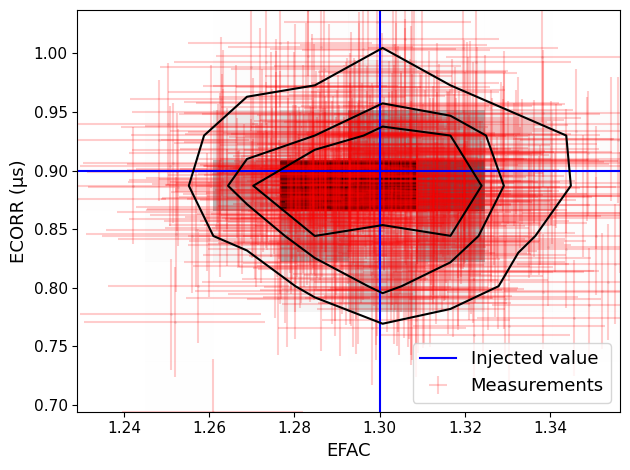

In [12]:
plt.errorbar(x=efac_vals, y=ecorr_vals, xerr=efac_errs, yerr=ecorr_errs, ls="", 
             label="Measurements", alpha=0.2, color="red")
plt.axvline(m.EFAC1.value, color="blue")
plt.axhline(m.ECORR1.value, color="blue", label="Injected value")
corner.hist2d(np.array(efac_vals), np.array(ecorr_vals), bins=8, smooth=0.3)
plt.xlabel("EFAC", fontsize=13)
plt.ylabel("ECORR (μs)", fontsize=13)
plt.legend(fontsize=13)
plt.tick_params(axis="both", labelsize=11)
plt.tight_layout()
plt.savefig("sim2-multisim.pdf")